# Chicago Car Crashes Analysis

The City of Chicago launched its data portal in 2010 as a 

In [29]:
from datetime import datetime
import numpy as np

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

import seaborn as sns
import matplotlib.pyplot as plt

import folium

## Import Data

Three distinct datasets are used in this analysis:
- Crashes
- People
- Socially Disadvantaged Districts

These datasets are large.  Specifying the specific columns to import for each dataset will limit the time it takes to bring them into dataframes, and will minimize system resources

In [2]:
crashes_usecols = ['LATITUDE','LONGITUDE','CRASH_RECORD_ID','CRASH_DATE','DEVICE_CONDITION',\
                   'WEATHER_CONDITION','LIGHTING_CONDITION','ALIGNMENT','ROADWAY_SURFACE_COND',\
                   'INJURIES_FATAL','INJURIES_INCAPACITATING','CRASH_HOUR','CRASH_DAY_OF_WEEK']

people_usecols = ['CRASH_RECORD_ID','SAFETY_EQUIPMENT','PHYSICAL_CONDITION']

In [3]:
# Import CSV files into DataFrames
crashes_df = pd.read_csv('Data/Traffic_Crashes_-_Crashes_20240412.csv', usecols=crashes_usecols)
people_df = pd.read_csv('Data/Traffic_Crashes_-_People_20240412.csv', usecols=people_usecols)

In [4]:
# Load the SHP file into a GeoDataFrame
districts_gdf = gpd.read_file('Data\SD_geo.shp')

## Initial Data Exploration
Crash count
Crash distribution


In [25]:
crashes_col_total = len(pd.read_csv('Data/Traffic_Crashes_-_Crashes_20240412.csv', nrows=0).columns)
people_col_total = len(pd.read_csv('Data/Traffic_Crashes_-_People_20240412.csv', nrows=0).columns)
pd.DataFrame({'Dataset':('Crashes','People'),
              'Initial Columns':(crashes_col_total, people_col_total),
              'Used Columns':(len(crashes_df.columns),len(people_df.columns)),
              'Records':(len(crashes_df.index),len(people_df.index))
             })

,Dataset,Initial Columns,Used Columns,Records
0,Crashes,48,14,816936
1,People,29,3,820814


## Preprocessing

Preprocessing discussion - for later

#### Crashes dataset
- Create flag for records within disadvantaged districts
- Create bins for: (1) roadway conditions, (2) roadway alignment, (3) roadway devices, (4) weather, (5) lighting, and (6) surface conditions

#### Map - Socially Disadvantaged Districts
Display an interactive map showing which parts of Chicago have been deemed 'socially disadvantaged'.

In [50]:
def plot_folium(gdf):
    # Project the geometries to a CRS that uses meters (here using Web Mercator)
    gdf_projected = gdf.to_crs(epsg=3857)

    # Calculate the centroids of the projected geometries
    centroids = gdf_projected.geometry.centroid
    
    # Convert these centroids back to the geographic CRS to plot on the map
    centroids = centroids.to_crs(epsg=4326)  # EPSG:4326 is the geographic CRS used by most web maps

    # Calculate the center of the map
    center = [centroids.y.mean()-.03, centroids.x.mean()]
    
    # Initialize the map
    m = folium.Map(location=center, zoom_start=11.2)

    # Simplify and add each geometry to the map
    for _, row in gdf.iterrows():
        sim_geo = row.geometry.simplify(0.005, preserve_topology=False)
        geo_j = folium.GeoJson(data=sim_geo.__geo_interface__,
                               style_function=lambda x: {'fillColor': 'blue', 'color': 'blue'})
        geo_j.add_to(m)

    return m

# Assuming 'districts_gdf' is your original GeoDataFrame
district_map = plot_folium(districts_gdf)
district_map

#### Geographic analysis
- Drop records without locations
- Convert the Crashes DataFrame into a GeoDataFrame so that the coordinates can be turned into Points using the Shapely package
- Ensure that the resulting GDF uses the same reference system as the imported districts GDF
- Spatially join the two GDFs, checking to see if each point is within one of the districts and assigning 1's to those
- Drop unnecessary columns and convert back to a DataFrame, which is computationally more efficient

In [5]:
# Drop values with no location information
crashes_df.dropna(subset=['LATITUDE','LONGITUDE'], inplace=True)

# Convert DataFrame into GeoDataFrame
crashes_df['geometry'] = crashes_df.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
crashes_gdf = gpd.GeoDataFrame(crashes_df, geometry='geometry')

# Ensure that both GeoDataFrames use the same CRS
crashes_gdf.crs = districts_gdf.crs

# Spatial join the GeoDataFrames
joined_gdf = gpd.sjoin(crashes_gdf, districts_gdf, how='left', predicate='within')

# Add flag for crashes that are within a district
joined_gdf['WITHIN_DISTRICT'] = joined_gdf['index_right'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Drop the geometry, index_right, LATITUDE and LONGITUDE columns
joined_gdf.drop(columns=['LATITUDE','LONGITUDE','geometry','index_right'], axis=1, inplace=True)

# Convert back to DataFrame
crashes_flag_df = pd.DataFrame(joined_gdf)

#### Prepare datetime data for analysis
- Create a helper function to convert each date to a season
- Convert each date string to a season
- Group days of the week into weekday/weekend categories
- Group hours of the day into thematic blocks
- Drop unnecessary columns

In [6]:
# Helper function to convert dates to seasons

def get_season(date):
    year = date.year
    seasons = [('winter', datetime(year, 1, 1).date(), datetime(year, 2, 28).date()),
               ('spring', datetime(year, 3, 1).date(), datetime(year, 5, 31).date()),
               ('summer', datetime(year, 6, 1).date(), datetime(year, 8, 31).date()),
               ('autumn', datetime(year, 9, 1).date(), datetime(year, 11, 30).date()),
               ('winter', datetime(year, 12, 1).date(), datetime(year, 12, 31).date())]
    if date.year % 4 == 0:  # leap year check
        seasons[0] = ('winter', datetime(year, 1, 1).date(), datetime(year, 2, 29).date())
    
    for season, start, end in seasons:
        if start <= date <= end:
            return season

    return 'Date is out of range'

In [7]:
# Convert date field to season
crashes_flag_df['SEASON'] = crashes_flag_df['CRASH_DATE'].apply(lambda x: 
                                                      get_season(datetime.strptime(x[:10],'%m/%d/%Y').date()))

# Group CRASH_DAY_OF_WEEK into weekdays and weekends
weekday_mask = [2,3,4,5,6]
crashes_flag_df['WEEKEND'] = crashes_flag_df['CRASH_DAY_OF_WEEK'].apply(lambda x: 0 if x in weekday_mask else 1)

# Group hours into time blocks (extra bin at end to ensure correct bin treatment)
bins = [-1, 6, 9, 15, 19, 23, 24]
labels = ['night', 'morning_rush', 'midday', 'evening_rush', 'night', 'night']
crashes_flag_df['TIME_BLOCK'] = pd.cut(crashes_flag_df['CRASH_HOUR'], bins=bins, labels=labels, right=True, ordered=False)

# Drop unnecessary columns
crashes_flag_df.drop(columns=['CRASH_DATE','CRASH_DAY_OF_WEEK','CRASH_HOUR'], axis=1, inplace=True)                                                      

#### Category flags
- Convert string categories into 1/0 where 1's signify potential dangerous conditions
- Categories include malfunctioning road device, bad weather conditions, poor lighting, non-straight and level roads and unsafe surfaces
- Create a target column equal to 1 if there are any fatal or incapacitating injuries
- Drop unnecessary columns

In [8]:
device_mask = ['NO CONTROLS','FUNCTIONING PROPERLY']
weather_mask = ['CLEAR','UNKNOWN']
lighting_mask = ['DAYLIGHT']
alignment_mask = ['STRAIGHT AND LEVEL']
surface_mask = ['DRY','UNKNOWN']

crashes_flag_df['Malfunctioning_Device'] = crashes_flag_df['DEVICE_CONDITION'].apply(lambda x: 0 if x in device_mask else 1)
crashes_flag_df['Inclement_Weather'] = crashes_flag_df['WEATHER_CONDITION'].apply(lambda x: 0 if x in weather_mask else 1)
crashes_flag_df['Not_Daylight'] = crashes_flag_df['LIGHTING_CONDITION'].apply(lambda x: 0 if x in lighting_mask else 1)
crashes_flag_df['Not_Straight_Level'] = crashes_flag_df['ALIGNMENT'].apply(lambda x: 0 if x in alignment_mask else 1)
crashes_flag_df['Not_Dry_Surface'] = crashes_flag_df['ROADWAY_SURFACE_COND'].apply(lambda x: 0 if x in surface_mask else 1)

# Flag for serious accidents (fatal + incapacitating), which is the target
crashes_flag_df['Target'] = crashes_flag_df.apply(lambda row: 1 if 
                                                  (row['INJURIES_FATAL']+row['INJURIES_INCAPACITATING'] > 0) else 0,
                                                  axis=1)

# Drop unnecessary columns
crashes_flag_df = crashes_flag_df.drop(columns=['DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',\
                                                'ALIGNMENT', 'ROADWAY_SURFACE_COND',\
                                               'INJURIES_FATAL', 'INJURIES_INCAPACITATING'], axis=1)

#### People Dataset
This dataset includes all people involved with any crash (e.g. the driver of each car, each passenger), so there is more than one line per crash.  Since this analysis predicts the effect of crashes, all relevant information must be extracted and processed into per-crash form.  This is accomplished by converting each feature into a single flag per crash.
- Flag vehicle operators with compromised physical features (e.g. alcohol, drugs, tired)
- Flag participants that failed to use vehicle safety equipment properly
- Group people by CRASH_ID and apply flag if applicable
- Drop unnecessary columns

In [9]:
# Masks to assist in binning the PHYSICAL_CONDITION and SAFETY_EQUIPMENT fields
PhysicalMask = ['NORMAL', 'UNKNOWN']
SafetyMask = ['SAFETY BELT USED', 'USAGE UNKNOWN', 'CHILD RESTRAINT USED', 'CHILD RESTRAINT - FORWARD FACING'\
             'BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)', 'CHILD RESTRAINT - TYPE UNKNOWN',\
             'CHILD RESTRAINT - REAR FACING', 'HELMET USED', 'DOT COMPLIANT MOTORCYCLE HELMET',\
             'BOOSTER SEAT', 'WHEELCHAIR', 'STRETCHER']

# Bin all problematic physical and safety conditions and tag with a 1 
people_df['PHYSICAL_FLAG'] = people_df['PHYSICAL_CONDITION'].apply(lambda x: 0 if x in PhysicalMask else 1)
people_df['SAFETY_FLAG'] = people_df['SAFETY_EQUIPMENT'].apply(lambda x: 0 if x in SafetyMask else 1)

# Drop the original columns
people_df = people_df.drop(columns=['PHYSICAL_CONDITION', 'SAFETY_EQUIPMENT'], axis=1)

# For each crash, tag if at least one element had a safety or physical problem
safety_flag = people_df.groupby('CRASH_RECORD_ID')['SAFETY_FLAG'].max().reset_index()
safety_flag.rename(columns={'SAFETY_FLAG': 'Poor_Safety_Behavior'}, inplace=True)
people_df = people_df.drop('SAFETY_FLAG', axis=1).merge(safety_flag, on='CRASH_RECORD_ID', how='left')

physical_flag = people_df.groupby('CRASH_RECORD_ID')['PHYSICAL_FLAG'].max().reset_index()
physical_flag.rename(columns={'PHYSICAL_FLAG': 'Incapacitated_Person'}, inplace=True)
people_df = people_df.drop('PHYSICAL_FLAG', axis=1).merge(physical_flag, on='CRASH_RECORD_ID', how='left')

# Drop remaining duplicate rows
people_df.drop_duplicates(inplace=True)

In [10]:
# Merge the dataframes
combined_df = crashes_flag_df.merge(people_df, on='CRASH_RECORD_ID', how='inner')

# Convert TIME_BLOCK and SEASON to type='category'
combined_df['TIME_BLOCK'] = combined_df['TIME_BLOCK'].astype('category')
combined_df['SEASON'] = combined_df['SEASON'].astype('category')

# Drop CRASH_RECORD_ID
combined_df.drop('CRASH_RECORD_ID', axis=1, inplace=True)

# Reset index
combined_df.reset_index(drop=True)

,WITHIN_DISTRICT,SEASON,WEEKEND,TIME_BLOCK,Malfunctioning_Device,Inclement_Weather,Not_Daylight,Not_Straight_Level,Not_Dry_Surface,Target,Poor_Safety_Behavior,Incapacitated_Person
0,1,summer,1,midday,0,0,0,0,0,0,0,0
1,0,summer,0,evening_rush,0,0,0,0,0,0,1,0
2,0,summer,1,midday,0,0,1,0,0,0,0,0
3,0,summer,1,night,0,0,1,0,0,0,0,0
4,0,autumn,0,midday,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
816539,0,summer,0,midday,0,0,0,0,0,0,0,0
816540,1,spring,0,night,1,0,1,0,0,0,0,0
816541,0,spring,0,evening_rush,0,0,1,0,0,0,0,0
816542,0,spring,0,night,0,1,1,0,1,0,0,0


## Modeling
- Baseline model
- Simple first model
- Final model

In [11]:
y = combined_df['Target']
X = combined_df.drop('Target', axis=1)

# Split the data into training and testing sets, stratify the split to ensure sufficient targets are in test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1023, stratify=y)

#### Baseline model
Our target variable is imbalanced.  The baseline model is a dummy classifier that selects for most frequent value.  Since over 98% of all crashes do not result in a fatality or serious injury, accuracy in this baseline model will be very high.

In [12]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
print("Baseline Accuracy:", dummy_clf.score(X_test, y_test))
print("Baseline ROC-AUC:", roc_auc_score(y_test, dummy_clf.predict_proba(X_test)[:, 1]))

Baseline Accuracy: 0.9819667011616017
Baseline ROC-AUC: 0.5


#### First simple model
As a first test to improve on the baseline, this model uses a decision tree with three variables:
- Weather
- The driver's use of appropriate safety features
- Driver's physical condition

C:\Users\Rick\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99    160364
           1       0.00      0.00      0.00      2945

    accuracy                           0.98    163309
   macro avg       0.49      0.50      0.50    163309
weighted avg       0.96      0.98      0.97    163309

Logistic Regression ROC-AUC: 0.752348885911038


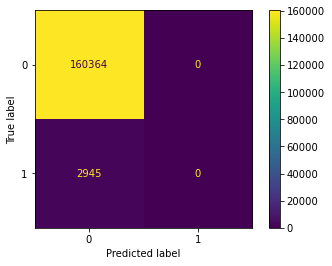

In [13]:
# Select variables for simple model
simple_cols = ['Inclement_Weather', 'Poor_Safety_Behavior', 'Incapacitated_Person']
X_train_simple = X_train[simple_cols]
X_test_simple = X_test[simple_cols]

# Instantiate a logistic regression
logreg_simple = LogisticRegression(random_state=1023)
logreg_simple.fit(X_train_simple, y_train)
y_pred = logreg_simple.predict(X_test_simple)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, logreg_simple.predict_proba(X_test_simple)[:, 1]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

Due to the severe imbalance in the target variable, the model does not successfully predict *any* positive cases (though the higher ROC-AUC suggests setting a lower probability threshold might lead to better predictions.

The next iteration adds many more variables to the regression to add more explanatory power to the model.

#### Logistic regression model


#### One Hot Encoding

In [ ]:
# One-hot encode categorical columns
ohe = OneHotEncoder(sparse=False, drop=['spring', 'midday'])
cat_columns = ['SEASON', 'TIME_BLOCK']

# Encode training data
X_train_ohe = ohe.fit_transform(X_train[cat_columns])
feature_names = ohe.get_feature_names(cat_columns)
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=feature_names, index=X_train.index)
X_train_final = pd.concat([X_train.drop(columns=cat_columns, axis=1), X_train_ohe_df], axis=1)

# Encode test data
X_test_ohe = ohe.transform(X_test[cat_columns])
feature_names = ohe.get_feature_names(cat_columns)
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=feature_names, index=X_test.index)
X_test_final = pd.concat([X_test.drop(columns=cat_columns, axis=1), X_test_ohe_df], axis=1)

C:\Users\Rick\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99    160364
           1       0.00      0.00      0.00      2945

    accuracy                           0.98    163309
   macro avg       0.49      0.50      0.50    163309
weighted avg       0.96      0.98      0.97    163309

Logistic Regression ROC-AUC: 0.7743198993088686


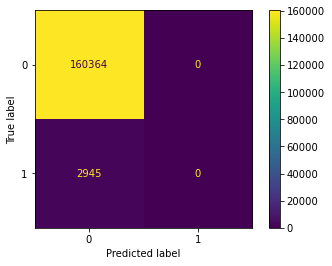

In [14]:
# Instantiate a new logistic regression object
logreg_complex = LogisticRegression(random_state=1023)

# Fit the object on the encoded training data 
logreg_complex.fit(X_train_final, y_train)

# Make predictions using the fitted model using the test data
y_pred_complex = logreg_complex.predict(X_test_final)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_complex)

# Display results
print(classification_report(y_test, y_pred_complex))
print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, logreg_complex.predict_proba(X_test_final)[:, 1]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

That improved the ROC-AUC marginally, but not the precision or recall.  The class imbalance is too great.

The next iteration will use SMOTE to address the imbalance.

#### Logistic Regression model with SMOTE


              precision    recall  f1-score   support

           0       0.99      0.71      0.83    160364
           1       0.04      0.73      0.08      2945

    accuracy                           0.71    163309
   macro avg       0.52      0.72      0.46    163309
weighted avg       0.98      0.71      0.81    163309

ROC-AUC: 0.7722717913520933


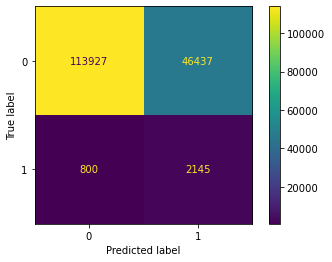

In [15]:
# Instantiate a SMOTE object
smote = SMOTE(random_state=1023)

# Apply SMOTE on one-hot encoded *training* data
X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train)

# Instantiate a new logistic regression object
logreg_smote = LogisticRegression(random_state=1023)

# Fit the object on the encoded training data
logreg_smote.fit(X_train_smote, y_train_smote)

# Make predictions using the fitted model
y_pred_smote = logreg_smote.predict(X_test_final)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_smote)

# Print results
print(classification_report(y_test, y_pred_smote))
print("ROC-AUC:", roc_auc_score(y_test, logreg_smote.predict_proba(X_test_final)[:, 1]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

This is much better.  Recall has improved significantly for true positives, but at the expense of true negatives.  Said another way, this model is making many correct predictions about severe car crashes, but also predicting some severe car crashes that do not happen.

Here is the predictive effect of each variable in the model.

In [16]:
# Features, coefficients and increased odds
odds_effect = []
for coef in logreg_smote.coef_[0]:
    odds_effect.append(f"{round(100*(np.exp(coef)-1),1)}%")

coefficients = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Coefficient': logreg_smote.coef_[0],
    'Odds Increase': odds_effect
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)

                    Feature  Coefficient Odds Increase
7      Poor_Safety_Behavior     2.051945        678.3%
8      Incapacitated_Person     1.189897        228.7%
14         TIME_BLOCK_night     0.641992         90.0%
0           WITHIN_DISTRICT     0.250086         28.4%
13  TIME_BLOCK_morning_rush     0.097271         10.2%
10            SEASON_summer     0.092347          9.7%
12  TIME_BLOCK_evening_rush     0.075787          7.9%
9             SEASON_autumn     0.055924          5.8%
1                   WEEKEND     0.054552          5.6%
3         Inclement_Weather     0.038844          4.0%
6           Not_Dry_Surface    -0.004982         -0.5%
11            SEASON_winter    -0.020861         -2.1%
5        Not_Straight_Level    -0.084764         -8.1%
4              Not_Daylight    -0.087671         -8.4%
2     Malfunctioning_Device    -0.199479        -18.1%


## Conclusion

For the future:
- Proximity to holidays
- Geographic proximity to hospital